## Feature Selection
```In this exercise you will experience a very under rated aspect of the data scientist job: feature selection.
We will look at the most common algorithms, examine them and will develop new feature selection algorithms.
The data you will be working on is pretty hard: you will soon find out why :)```

```Note: When questions are asked (you can identify a question by '?'), answer it in another cell and be prepared to talk about it with your tutor.```

```~Ittai Haran```

In [68]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

```Load data.csv. The data is made up from some measurements of soil in Africa, and was derived from Kaggle. SOC is the target.
```

In [69]:
df = pd.read_csv('resources/data.csv')

In [21]:
df.shape

(1157, 3595)

```Train a simple Random Forest model on the data. Use your knowledge to make it as good a model as you can. Don't forget to split the data to train and test segments.```

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, Y_train, Y_test = train_test_split(df.drop('SOC', axis=1), df['SOC'], train_size=0.8)

rf_model = RandomForestRegressor(random_state=32)

max_features = ['sqrt', 'log2']
min_samples_split = [1, 2, 5, 10, 15, ]
min_samples_leaf = [1, 2, 4, 5, 10]
bootstrap = [True, False]
n_estimators = [40, 90, 100, 110, 120, 130, 140, 150, 200, 210, 220, 230, 240, 250]
max_depth = [int(x) for x in np.linspace(10, 130, num=11)]
max_depth.append(None)

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               }

random_model = RandomizedSearchCV(estimator=rf_model, param_distributions=random_grid,
                                  n_iter=100, verbose=2, random_state=32, n_jobs=-1,
                                  return_train_score=True, cv=3)

random_model.fit(X_train, Y_train)
print(random_model.best_params_)

print("Train MSE", mean_squared_error(random_model.predict(X_train), Y_train))
print("Test MSE", mean_squared_error(random_model.predict(X_test), Y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.9min finished


{'n_estimators': 230, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 82, 'bootstrap': False}
Train MSE 0.00527644249843506
Test MSE 0.18601945686601346


```Use model.feature_importances_ to select the 100 most important features. Use these features to train your model. Did you get better results on the train segment? what are results on the test segment?
How does model.feature_importances_ work? Some features have 0 importance. Why?```

In [27]:
best_features = {'n_estimators': 230, 'min_samples_split': 5, 'min_samples_leaf': 2, 
                 'max_features': 'sqrt', 'max_depth': 82, 'bootstrap': False}

rf_model = RandomForestRegressor(random_state=32, **best_features)
rf_model.fit(X_train, Y_train)

print("Train MSE", mean_squared_error(rf_model.predict(X_train), Y_train))
print("Test MSE", mean_squared_error(rf_model.predict(X_test), Y_test))

Train MSE 0.00527644249843506
Test MSE 0.18601945686601346


In [29]:
importance = rf_model.feature_importances_
indices = np.argsort(importance)

indices_100 = indices[-100:]
features_100 = df.columns[indices_100]

In [30]:
X_train_100 = X_train[features_100]
X_test_100 = X_test[features_100]

print("X_train_100", X_train_100.shape)

X_train_100 (925, 100)


In [33]:
rf_model = RandomForestRegressor(random_state=32)

random_model = RandomizedSearchCV(estimator=rf_model, param_distributions=random_grid,
                                  n_iter=100, verbose=2, random_state=32, n_jobs=-1,
                                  return_train_score=True, cv=3)

random_model.fit(X_train_100, Y_train)
print(random_model.best_params_)

print("Train MSE", mean_squared_error(random_model.predict(X_train_100), Y_train))
print("Test MSE", mean_squared_error(random_model.predict(X_test_100), Y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   31.9s finished


{'n_estimators': 230, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 34, 'bootstrap': False}
Train MSE 1.2374718901049124e-29
Test MSE 0.3217176626314219


In [40]:
X_train.shape

(925, 3594)

```Well, that didn't work quite so good. Let's try a different approach. Now select the 100 features that are most correlated to the data. What results did you get now? You got so far two groups of feature selected. Are they similar to one another? Why or why not?```

In [46]:
correlations_features = []

for feature in X_train.columns:
    correlations_features.append(np.corrcoef(X_train[feature], Y_train)[0][1])
    
indices = np.argsort(correlations_features)

indices_100 = indices[-100:]
features_100_correlation = df.columns[indices_100]

In [47]:
rf_model = RandomForestRegressor(random_state=32)

random_model = RandomizedSearchCV(estimator=rf_model, param_distributions=random_grid,
                                  n_iter=100, verbose=2, random_state=32, n_jobs=-1,
                                  return_train_score=True, cv=3)

random_model.fit(X_train[features_100_correlation], Y_train)
print(random_model.best_params_)

print("Train MSE", mean_squared_error(random_model.predict(X_train[features_100_correlation]), Y_train))
print("Test MSE", mean_squared_error(random_model.predict(X_test[features_100_correlation]), Y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   37.8s finished


{'n_estimators': 110, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 118, 'bootstrap': True}
Train MSE 0.3961021466768514
Test MSE 0.6794696415158282


```Now cluster the features by their correlation to one another. Make sure you have at least ~30 clusters. Pick from each cluster the feature most correlated to the target. What are your results now? What clustering algorithm did you use?```

In [53]:
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans

df_transpose = X_train.transpose()

norma = Normalizer()
df_transpose = norma.fit_transform(df_transpose)

kmeans_model = KMeans(n_clusters=30, n_jobs=-1)
features_clustering = kmeans_model.fit_predict(df_transpose)

correlation_dict = dict(zip(df.columns, correlations_features))
feature_importance_list = []
for feature in X_train.columns:
    feature_importance_list.append(correlation_dict[feature])

df_features = pd.DataFrame({
    "kmeans_predict": features_clustering,
    "feature_correlation": feature_importance_list,
    "name_features": X_train.columns
})

features_clustering 3594
name_features 3594
kmeans_predict 3594


In [55]:
ranking_features = df_features.groupby("kmeans_predict").apply(lambda x: x.loc[x['feature_correlation'] == x['feature_correlation'].max(),
                                                            ['feature_correlation', 'name_features']])

In [61]:
features_selected = ranking_features['name_features'].values

In [62]:
rf_model = RandomForestRegressor(random_state=32)

random_model = RandomizedSearchCV(estimator=rf_model, param_distributions=random_grid,
                                  n_iter=100, verbose=2, random_state=32, n_jobs=-1,
                                  return_train_score=True, cv=3)

random_model.fit(X_train[features_selected], Y_train)
print(random_model.best_params_)

print("Train MSE", mean_squared_error(random_model.predict(X_train[features_selected]), Y_train))
print("Test MSE", mean_squared_error(random_model.predict(X_test[features_selected]), Y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   32.3s finished


{'n_estimators': 110, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 118, 'bootstrap': False}
Train MSE 0.021266110304232224
Test MSE 0.22318691611849978


```Before we continue, read the documentation of sklearn.feature_selection. What other feature selection algorithms did you find there? try one of them on your data.```

In [74]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE

sel = VarianceThreshold(threshold=(.97 * (1 - .97)))

X_train_variance = sel.fit_transform(X_train)
X_test_variance = sel.transform(X_test)

print("X_train_variance", X_train_variance.shape)
print("X_test_variance", X_test_variance.shape)

best_params = {'n_estimators': 110, 'min_samples_split': 5, 'min_samples_leaf': 2, 
               'max_features': 'sqrt', 'max_depth': 118, 'bootstrap': False}
estimator = RandomForestRegressor(random_state=32, **best_params)
selector = RFE(estimator, n_features_to_select=100, step=50)
selector = selector.fit(X_train, Y_train)

X_train_variance_RF = X_train_variance[selector.support_]
X_test_variance_RF = X_test_variance[selector.support_]

print("X_train_variance_RF", X_train_variance.shape)
print("X_test_variance_RF", X_test_variance.shape)

X_train_variance (925, 923)
X_test_variance (232, 923)


KeyboardInterrupt: 

```You are about to be very surprised. select 100 features randomly and evaluate the model trained with them. Repeat it 100 times. What is the best set of feature you got? How is it compared to the other subsets you got so far? Can you explain it?```

In [88]:
max_features = ['sqrt', 'log2']
min_samples_split = [1, 2, 5, 10, 15, ]
min_samples_leaf = [1, 2, 4, 5, 10]
bootstrap = [True, False]
n_estimators = [40, 90, 100, 110, 120, 130, 140, 150, 200, 210, 220, 230, 240, 250]
max_depth = [int(x) for x in np.linspace(10, 130, num=11)]
max_depth.append(None)

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               }

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [10:27<00:00,  6.28s/it]


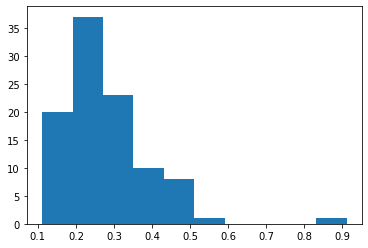

In [89]:
from tqdm import tqdm

test_MSE = []
best_features = []
best_MSE = 100

for i in tqdm(range(100)):
    selected_indices_features = np.random.randint(0, len(X_train.columns), 100)
    selected_features = X_train.columns[selected_indices_features]
    
    rf_model = RandomForestRegressor(random_state=32)

    random_model = RandomizedSearchCV(estimator=rf_model, param_distributions=random_grid,
                                      n_iter=20, verbose=0, random_state=32, n_jobs=-1,
                                      return_train_score=True, cv=3)
    
    X_train_train, X_train_val, Y_train_train, Y_train_val = train_test_split(X_train, Y_train, train_size=0.8)
    
    random_model.fit(X_train_train[selected_features], Y_train_train)
    MSE_features = mean_squared_error(random_model.predict(X_train_val[selected_features]), Y_train_val)
    test_MSE.append(MSE_features)
    
    if MSE_features < best_MSE:
        best_MSE = MSE_features
        best_features = selected_features
    
plt.hist(test_MSE)
plt.show()

In [90]:
rf_model = RandomForestRegressor(random_state=32)

random_model = RandomizedSearchCV(estimator=rf_model, param_distributions=random_grid,
                                  n_iter=20, verbose=0, random_state=32, n_jobs=-1,
                                  return_train_score=True, cv=3)

X_train_train, X_train_val, Y_train_train, Y_train_val = train_test_split(X_train, Y_train, train_size=0.8)

random_model.fit(X_train_train[selected_features], Y_train_train)
MSE_features = mean_squared_error(random_model.predict(X_test[selected_features]), Y_test)

print(MSE_features)

0.21071278289786363


```Now it's your time to enter the office's competition for feature selection. Invent your own feature selection algorithm. Make it a good one (because if it isn't, your tutor might ask you to implement one of the other algorithms proposed by the office's members, and that might be awful ;) ) Before you act, talk about your idea with your tutor.```

In [79]:
def SU(x_i, x_j):
    def entropy(labels, base=None):
        """ Computes entropy of label distribution. """
        n_labels = len(labels)
        if n_labels <= 1:
            return 0
        value, counts = np.unique(labels, return_counts=True)
        probs = counts / n_labels
        n_classes = np.count_nonzero(probs)
        if n_classes <= 1:
            return 0
        ent = 0.
        # Compute entropy
        base = e if base is None else base
        for i in probs:
            ent -= i * log(i, base)
        return ent

    return 2 * (mutual_info_score(x_i, x_j) / (entropy(x_i) + entropy(x_j)))

In [87]:
def corrcoef(x_i, x_j):
    return np.corrcoef(x_i, x_j)[0][1]

In [103]:
def FCBF(X, C, features_name, metric=SU, delta=0.05):
    """
    https://www.aaai.org/Papers/ICML/2003/ICML03-111.pdf
    """

    N = X.shape[1]
    S_list = []
    for i in range(N):
        SU_i_c = metric(X[:, i], C)

        if SU_i_c > delta:
            S_list.append((i, SU_i_c, features_name[i]))
    
    S_list = sorted(S_list, key=lambda x: x[1], reverse=True)
    S_list.append(("end", ""))
    S_list.append(("end", ""))
 
    idx_p = 0
    Fp = S_list[idx_p]
    
    while Fp[0] != "end":
        idx_q = idx_p + 1
        Fq = S_list[idx_q]
        while Fq[0] != "end":
            if metric(X[:, Fp[0]], X[:, Fq[0]]) > Fq[1]:
                S_list.remove(Fq)
                Fq = S_list[idx_q]
            else:
                idx_q += 1
                Fq = S_list[idx_q]
        idx_p += 1
        Fp = S_list[idx_p]
        
    
    S_list.remove(("end", ""))
    S_list.remove(("end", ""))
    return S_list

In [104]:
from sklearn.metrics import mutual_info_score
from math import log, e

features_FCBF_SU = FCBF(X_train.values, Y_train.values, X_train.columns)

In [105]:
print(features_FCBF_SU)

[(74, 0.8813152589477815, 'm7357.18')]


In [106]:
features_FCBF_corr = FCBF(X_train.values, Y_train.values, X_train.columns, metric=corrcoef)

In [107]:
print(features_FCBF_corr)

[(2585, 0.6145894749051034, 'm2514.75'), (3591, 0.40651913550859287, 'RELI'), (3592, 0.343908230369229, 'TMAP')]


In [52]:
def train_model(features):
    rf_model = RandomForestRegressor(random_state=32)

    random_model = RandomizedSearchCV(estimator=rf_model, param_distributions=random_grid,
                                      n_iter=100, verbose=2, random_state=32, n_jobs=-1,
                                      return_train_score=True, cv=3)

    random_model.fit(X_train[features], Y_train)
    print(random_model.best_params_)

    print("Train MSE", mean_squared_error(random_model.predict(X_train[features]), Y_train))
    print("Test MSE", mean_squared_error(random_model.predict(X_test[features]), Y_test))

In [111]:
features_FCBF_corr = [x[2] for x in features_FCBF_corr]

train_model(features_FCBF_corr)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 293 out of 300 | elapsed:   14.4s remaining:    0.2s


{'n_estimators': 120, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 46, 'bootstrap': False}
Train MSE 0.1500970307724527
Test MSE 0.4804836990781411


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   14.9s finished


In [109]:
features_FCBF_SU = [x[2] for x in features_FCBF_SU]

train_model(features_FCBF_SU)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 293 out of 300 | elapsed:   14.9s remaining:    0.3s


{'n_estimators': 40, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 82, 'bootstrap': True}
Train MSE 0.851980139145294
Test MSE 1.5049516927496727


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   15.5s finished


In [112]:
train_model(features_FCBF_SU + features_FCBF_corr)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   17.1s finished


{'n_estimators': 220, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 118, 'bootstrap': True}
Train MSE 0.12346901134934281
Test MSE 0.40698895186229084


In [4]:
import xgboost as xgb
import shap

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, Y_train, Y_test = train_test_split(df.drop('SOC', axis=1), df['SOC'], train_size=0.8)


In [5]:
classifier = xgb.XGBRegressor(use_label_encoder=False, learning_rate=0.02, n_estimators=150, nthread=1)

In [6]:
random_grid = {"max_depth": np.linspace(2, 15, 10, dtype=int),
               "reg_alpha": np.logspace(-5, 0, 5),
               "reg_lambda": np.logspace(-5, 0, 5),
               'min_child_weight': [1, 5, 10],
               'gamma': [0.5, 1, 1.5, 2, 5],
               'subsample': [0.6, 0.8, 1.0],
               'colsample_bytree': [0.6, 0.8, 1.0],
              }

In [7]:
random_model = RandomizedSearchCV(estimator=classifier, param_distributions=random_grid,
                                  n_iter=5, verbose=1, random_state=42, n_jobs=-1,
                                  return_train_score=True, cv=3)

In [8]:
random_model.fit(X_train, Y_train)

print("Train MSE", mean_squared_error(random_model.predict(X_train), Y_train))
print("Test MSE", mean_squared_error(random_model.predict(X_test), Y_test))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.6min finished


Train MSE 0.03623252403198846
Test MSE 0.18607495502653865


In [9]:
print(random_model.best_params_)
best_params = random_model.best_params_

{'subsample': 1.0, 'reg_lambda': 0.00017782794100389227, 'reg_alpha': 0.0031622776601683794, 'min_child_weight': 10, 'max_depth': 6, 'gamma': 0.5, 'colsample_bytree': 0.6}


In [11]:
classifier = xgb.XGBRegressor(use_label_encoder=False, learning_rate=0.02, n_estimators=150, nthread=1, **best_params)
classifier.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=6,
             min_child_weight=10, missing=nan, monotone_constraints='()',
             n_estimators=150, n_jobs=1, nthread=1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0,
             reg_alpha=0.0031622776601683794, reg_lambda=0.00017782794100389227,
             scale_pos_weight=1, subsample=1.0, tree_method='exact',
             use_label_encoder=False, validate_parameters=1, verbosity=None)

In [22]:
shap_class = shap.explainers.Tree(classifier, data=X_train, feature_names=X_train.columns)
shap_values = shap_class.shap_values(X_train, y=Y_train)

In [21]:
shap.plots.waterfall(shap_values, max_display=20)

Exception: waterfall_plot requires a scalar base_values of the model output as the first parameter, but you have passed an array as the first parameter! Try shap.waterfall_plot(explainer.base_values[0], values[0], X[0]) or for multi-output models try shap.waterfall_plot(explainer.base_values[0], values[0][0], X[0]).

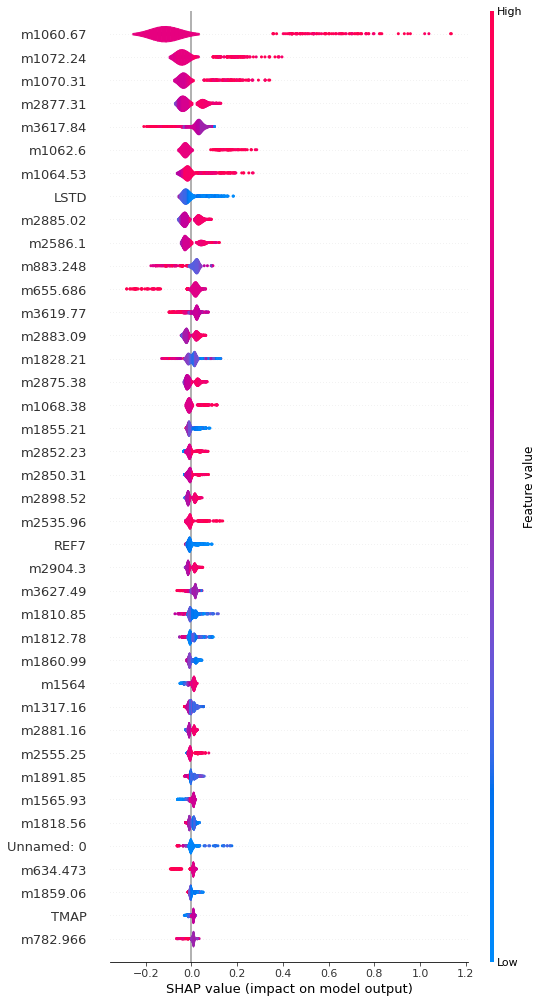

In [29]:
shap.summary_plot(shap_values, X_train, plot_type="violin", max_display=40)

['m782.966', 'TMAP', 'm1859.06', 'm634.473', 'Unnamed: 0', 'm1818.56', 'm1565.93', 'm1891.85', 'm2555.25', 'm2881.16', 'm1317.16', 'm1564', 'm1860.99', 'm1812.78', 'm1810.85', 'm3627.49', 'm2904.3', 'REF7', 'm2535.96', 'm2898.52', 'm2850.31', 'm2852.23', 'm1855.21', 'm1068.38', 'm2875.38', 'm1828.21', 'm2883.09', 'm3619.77', 'm655.686', 'm883.248', 'm2586.1', 'm2885.02', 'LSTD', 'm1064.53', 'm1062.6', 'm3617.84', 'm2877.31', 'm1070.31', 'm1072.24', 'm1060.67']


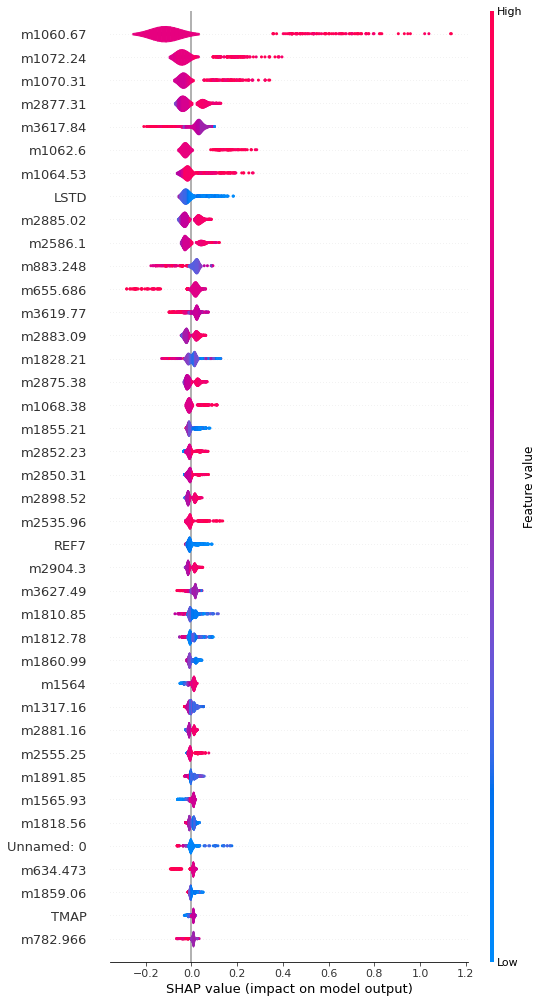

In [50]:
shap.summary_plot(shap_values, X_train, plot_type="violin", max_display=40, show=False)

ax = plt.gca()
major_ticks = ax.yaxis.majorTicks
features_shap = []
for tick in major_ticks:
    features_shap.append(tick.label1.get_text())

print(features_shap)

In [45]:
classifier = xgb.XGBRegressor(use_label_encoder=False, learning_rate=0.02, n_estimators=150, nthread=1, **best_params)
classifier.fit(X_train, Y_train)

Text(3.200000000000003, 0.5, '')


In [56]:
train_model(features_shap)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   31.2s finished


{'n_estimators': 230, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 22, 'bootstrap': False}
Train MSE 7.147600648909453e-10
Test MSE 0.19810303944964122


In [58]:
classifier = xgb.XGBRegressor(use_label_encoder=False, learning_rate=0.02, n_estimators=150, nthread=1)
random_grid = {"max_depth": np.linspace(2, 15, 10, dtype=int),
               "reg_alpha": np.logspace(-5, 0, 5),
               "reg_lambda": np.logspace(-5, 0, 5),
               'min_child_weight': [1, 5, 10],
               'gamma': [0.5, 1, 1.5, 2, 5],
               'subsample': [0.6, 0.8, 1.0],
               'colsample_bytree': [0.6, 0.8, 1.0],
              }
random_model = RandomizedSearchCV(estimator=classifier, param_distributions=random_grid,
                                  n_iter=5, verbose=1, random_state=42, n_jobs=-1,
                                  return_train_score=True, cv=3)
random_model.fit(X_train[features_shap], Y_train)

print("Train MSE", mean_squared_error(random_model.predict(X_train[features_shap]), Y_train))
print("Test MSE", mean_squared_error(random_model.predict(X_test[features_shap]), Y_test))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.1s finished


Train MSE 0.04998221928733055
Test MSE 0.20076984046334484


In [81]:
def feature_selction_SHAP(X, y, feature_names, nb_features, classification=True, n_iter=20):
    if classification is True:
        classifier = xgb.XGBClassifier(use_label_encoder=False, random_state=32)
    else:
        classifier = xgb.XGBRegressor(use_label_encoder=False, random_state=32)
    
    X_train_train, X_train_val, Y_train_train, Y_train_val = train_test_split(X, y, train_size=0.8)
    
    random_grid = {"n_estimators": np.linspace(10, 150, 10, dtype=int),
                   "max_depth": np.linspace(2, 15, 10, dtype=int),
                   "learning_rate": np.logspace(-5, 0, 15),
                   "reg_alpha": np.logspace(-5, 0, 5),
                   "reg_lambda": np.logspace(-5, 0, 5),
                   'min_child_weight': [1, 5, 10],
                   'gamma': [0.5, 1, 1.5, 2, 5],
                   'subsample': [0.6, 0.8, 1.0],
                   'colsample_bytree': [0.6, 0.8, 1.0],
                  }

    random_model = RandomizedSearchCV(estimator=classifier, param_distributions=random_grid,
                                      n_iter=n_iter, verbose=0, random_state=42, n_jobs=-1,
                                      return_train_score=True, cv=3)

    random_model.fit(X_train_train, Y_train_train)
    classifier = random_model.best_estimator_
    
    shap_class = shap.explainers.Tree(classifier, data=X_train_val, feature_names=feature_names)
    shap_values = shap_class.shap_values(X_train_val, y=Y_train_val)
    shap.summary_plot(shap_values, X_train_val, plot_type="violin", max_display=nb_features, show=False)

    ax = plt.gca()
    major_ticks = ax.yaxis.majorTicks
    features_shap = []
    for tick in major_ticks:
        features_shap.append(tick.label1.get_text())
    
    return features_shap

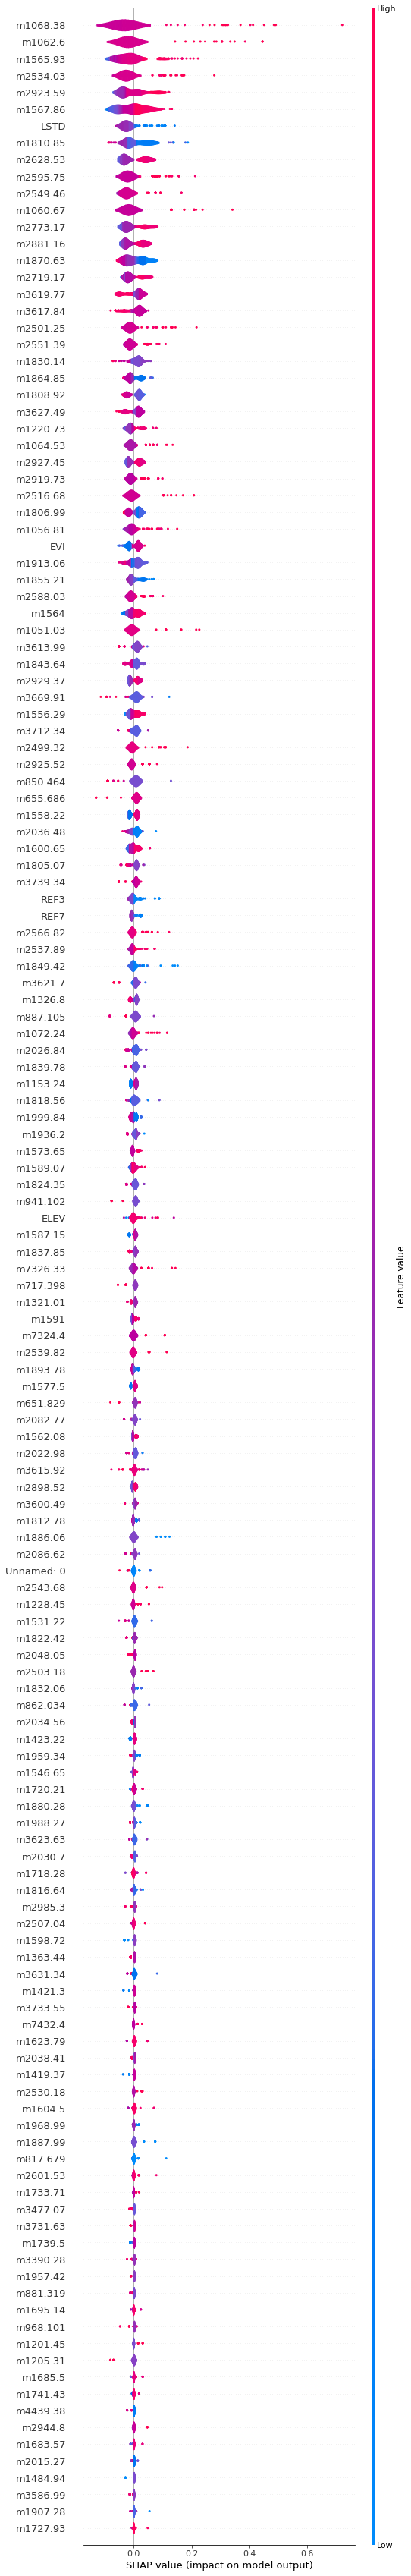

In [82]:
features_SHAP = feature_selction_SHAP(X_train, Y_train, X_train.columns, nb_features=150, classification=False)

In [83]:
max_features = ['sqrt', 'log2']
min_samples_split = [1, 2, 5, 10, 15, ]
min_samples_leaf = [1, 2, 4, 5, 10]
bootstrap = [True, False]
n_estimators = [40, 90, 100, 110, 120, 130, 140, 150, 200, 210, 220, 230, 240, 250]
max_depth = [int(x) for x in np.linspace(10, 130, num=11)]
max_depth.append(None)

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               }

train_model(features_SHAP)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   36.7s finished


{'n_estimators': 230, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 22, 'bootstrap': False}
Train MSE 6.695660030026868e-10
Test MSE 0.15027333478188806


In [85]:
classifier = xgb.XGBRegressor(use_label_encoder=False, learning_rate=0.02, n_estimators=150, nthread=1)
random_grid = {"max_depth": np.linspace(2, 15, 10, dtype=int),
               "reg_alpha": np.logspace(-5, 0, 5),
               "reg_lambda": np.logspace(-5, 0, 5),
               'min_child_weight': [1, 5, 10],
               'gamma': [0.5, 1, 1.5, 2, 5],
               'subsample': [0.6, 0.8, 1.0],
               'colsample_bytree': [0.6, 0.8, 1.0],
              }
random_model = RandomizedSearchCV(estimator=classifier, param_distributions=random_grid,
                                  n_iter=100, verbose=1, random_state=42, n_jobs=-1,
                                  return_train_score=True, cv=3)
random_model.fit(X_train[features_SHAP], Y_train)

print("Train MSE", mean_squared_error(random_model.predict(X_train[features_SHAP]), Y_train))
print("Test MSE", mean_squared_error(random_model.predict(X_test[features_SHAP]), Y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.8min finished


Train MSE 0.03186833411206924
Test MSE 0.18429512546123897


In [98]:
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVR

clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVR(random_state=0, tol=1e-5))),
  ('classification', RandomForestRegressor())
])
# clf.fit(X_train, Y_train)

max_features = ['sqrt', 'log2']
min_samples_split = [1, 2, 5, 10, 15, ]
min_samples_leaf = [1, 2, 4, 5, 10]
bootstrap = [True, False]
n_estimators = [40, 90, 100, 110, 120, 130, 140, 150, 200, 210, 220, 230, 240, 250]
max_depth = [int(x) for x in np.linspace(10, 130, num=11)]
max_depth.append(None)

random_grid = {'classification__n_estimators': n_estimators,
               'classification__max_features': max_features,
               'classification__max_depth': max_depth,
               'classification__min_samples_split': min_samples_split,
               'classification__min_samples_leaf': min_samples_leaf,
               'classification__bootstrap': bootstrap,
               }

random_model = RandomizedSearchCV(estimator=clf, param_distributions=random_grid,
                                  n_iter=100, verbose=1, random_state=42, n_jobs=-1,
                                  return_train_score=True, cv=3)

random_model.fit(X_train, Y_train)

print("Train MSE", mean_squared_error(random_model.predict(X_train), Y_train))
print("Test MSE", mean_squared_error(random_model.predict(X_test), Y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 12.3min finished
Liblinear failed to converge, increase the number of iterations.


Train MSE 0.002492141727390231
Test MSE 0.17833980775270764
